In [1]:
from validphys.api import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from validphys.fkparser import load_fktable
from collections import defaultdict
from typing import List, Dict
from collections import namedtuple

from n3fit.layers import DIS

from gen_dicts import generate_dicts
from utils import XGRID, extract_independent_columns
from model_utils import *

Using Keras backend


In [2]:
seed = 14132124
DEBUG = False

In [3]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [4]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data

In [5]:
# Construct the big FK table matrix
ndata = 0
for fk in fk_table_dict.values():
  ndata += fk.shape[0]

FK = np.vstack([fk.numpy().reshape((fk.shape[0], fk.shape[1] * fk.shape[2])) for fk in fk_table_dict.values()])

try:
  assert(FK.shape[0] == ndata)
except AssertionError:
  print('The number of points does not match.')

# Perform singular value decomposition
fk_l, fk_evals, fk_r = np.linalg.svd(FK)

for idx, val in enumerate(fk_evals):
  print(f'{idx} : {val}')

0 : 108.40599822998047
1 : 104.26300811767578
2 : 99.8062515258789
3 : 96.13958740234375
4 : 93.28633117675781
5 : 89.17032623291016
6 : 85.46747589111328
7 : 82.43325805664062
8 : 78.22171783447266
9 : 73.54110717773438
10 : 61.730709075927734
11 : 55.10063934326172
12 : 49.780094146728516
13 : 45.8709831237793
14 : 39.89619064331055
15 : 32.68745803833008
16 : 26.800718307495117
17 : 25.57478904724121
18 : 18.776426315307617
19 : 17.752408981323242
20 : 15.906761169433594
21 : 13.151390075683594
22 : 12.943547248840332
23 : 12.117106437683105
24 : 10.707345962524414
25 : 10.439668655395508
26 : 10.418147087097168
27 : 10.03699779510498
28 : 7.709445953369141
29 : 7.311756610870361
30 : 6.263463973999023
31 : 6.017333030700684
32 : 5.891967296600342
33 : 5.685206890106201
34 : 5.381591320037842
35 : 5.045845031738281
36 : 5.0239105224609375
37 : 4.767819881439209
38 : 4.578884124755859
39 : 4.268607139587402
40 : 4.1912994384765625
41 : 4.168041229248047
42 : 3.972564935684204
43 : 3.

In [6]:
# Generate the model and compute the NTK
nnpdf = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=1235, name='NNPDF', kernel_initializer=tf.keras.initializers.GlorotNormal, predictions=False, dtype='float64')
NTK = compute_ntk(nnpdf, XGRID, round_to_zero=True, only_diagonal=True)

# Compute predictions at initialization
f0 = nnpdf(XGRID).numpy()

In [7]:
C_sys = API.dataset_inputs_t0_covmat_from_systematics(**common_dict)
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C.to_pickle(path='./serialised_data/covmat.pkl')
C_index = C.index
C_col = C.columns
#C = pd.DataFrame(C_sys, index=C_index, columns=C_col)
#C = pd.DataFrame(np.identity(C.shape[0]), index=C_index, columns=C_col)
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)

L = np.linalg.cholesky(Cinv)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf_doc/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


### Compute and regularise matrix $ M = (FK)^{T} C_{Y}^{-1} (FK)$.

In [8]:
M = np.zeros((50, 9, 50, 9))
for exp, fk in fk_table_dict.items():
  Cinv_red = Cinv.xs(level='dataset', key=exp).T.xs(level='dataset', key=exp)
  #R_fk = np.einsum('fF, nxF -> nxf', R, fk) 
  aux = np.einsum('Ixf, IJ -> xfJ', fk, Cinv_red)
  M += np.einsum('xfI, IXF -> xfXF', aux, fk)

oldshape = M.shape
prod = 1
invshape = oldshape[2:] + oldshape[:2]
for k in oldshape[2:]:
    prod *= k
M_old_shape = M
M = M.reshape(prod, -1)

In [9]:
# Regularization term from GD
M_gd = M.T @ NTK.reshape(prod, -1) @ M 

In [10]:
eta_id = 0.001
eta_gd = 0.0
Mr = M + eta_id * np.identity(M.shape[0]) + eta_gd * M_gd
Mr_old_shape = Mr.reshape(*oldshape)
M_inv = np.linalg.inv(Mr)
M_inv = M_inv.reshape(*oldshape)

In [11]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

Cinv_Y = Cinv @ Y

FK_Cinv_y = np.zeros((50,9))
for exp, fk in fk_table_dict.items():
  Cinv_Y_red = Cinv_Y.xs(level='dataset', key=exp).to_numpy()
  #R_fk = np.einsum('fF, nxF -> nxf', R, fk)
  FK_Cinv_y += np.einsum('Ixf, I -> xf', fk, Cinv_Y_red[:,0])

K = np.einsum('xfXF , XF -> xf', M_inv, FK_Cinv_y)

### Compute the matrix that governs the evolution $H = \Theta M$

In [12]:
# Compute the matrix that controls the evolution
#H = NTK @ Mr
H = np.einsum('iajb, jbkc -> iakc', NTK, Mr_old_shape)
#H = np.einsum('iajb, jbkc -> iakc', M_old_shape, tmp)
print(f'The shape of H is {H.shape}')

H = H.reshape(prod, -1)
try:
  assert(np.allclose(H, H.T))
except AssertionError as e:
  print("Matrix H is not symmetric")

# Check if flatten H is the same as tensor H
try:
  H_flat = NTK.reshape(prod,-1) @ Mr
  assert(np.allclose(H_flat, H))
except AssertionError:
  print('Flat and tensor H are not the same.')

# Compute eigenvalues of the matrix H
eigvals_complex, eigvecs_complex = np.linalg.eig(H)
eigvals = eigvals_complex.real
eigvecs = eigvecs_complex.real

# Perform SVD decomposition
H_SVD = np.linalg.svd(H)
SVD_H_eigvecs_l = H_SVD[0]
SVD_H_eigvals = H_SVD[1]
SVD_H_eigvecs_r = H_SVD[2]

The shape of H is (50, 9, 50, 9)
Matrix H is not symmetric


Regularise the eigenvalues of H

In [13]:
# Extract independent eigenvectors (probably no longer needed)
ind_eigvecs, ind_idx = extract_independent_columns(eigvecs)
ind_eigvals = eigvals[ind_idx]

# regularise all eigenvalues
#regularised_eigvals = np.zeros_like(eigvals)
#for i in range(regularised_eigvals.size):
#  regularised_eigvals[i] = round_float32(eigvals[i], np.sort(eigvals)[::-1][0])

# Regularise only independent eigevalues
#ind_reg_eigvals = np.zeros_like(ind_eigvals)
#for i in range(ind_reg_eigvals.size):
#  ind_reg_eigvals[i] = round_float32(ind_eigvals[i], np.sort(ind_eigvals)[::-1][0])

# Regularise eigevalues SVD
SVD_H_eigvals_reg = np.zeros_like(SVD_H_eigvals)
for i in range(SVD_H_eigvals.size):
  SVD_H_eigvals_reg[i] = round_float32(SVD_H_eigvals[i], np.sort(SVD_H_eigvals)[::-1][0], tol_magnitude=1.e-8)

In [14]:
# Print singluar values (regularised)
for idx, val in enumerate(SVD_H_eigvals_reg):
  print(f'{idx}: {val}')

0: 40360546.60498439
1: 3014030.8386309724
2: 1189796.6210634902
3: 508112.72913894505
4: 267459.3366398547
5: 224810.78672024503
6: 170736.88310305594
7: 108031.16153146225
8: 100765.3512800981
9: 47013.33131625704
10: 41923.742864475316
11: 17911.42954536457
12: 11555.38377613694
13: 9709.810530157827
14: 8242.245309495966
15: 5672.703906768246
16: 3556.6663943337635
17: 784.3026586046965
18: 150.76464166976422
19: 59.11060217818878
20: 22.33610506811359
21: 17.585893742623245
22: 7.953321796726452
23: 6.460811582170728
24: 5.749921014599765
25: 4.055337783926171
26: 1.3844771052536258
27: 0.8181219444973422
28: 0.43881672283553025
29: 0.0
30: 0.0
31: 0.0
32: 0.0
33: 0.0
34: 0.0
35: 0.0
36: 0.0
37: 0.0
38: 0.0
39: 0.0
40: 0.0
41: 0.0
42: 0.0
43: 0.0
44: 0.0
45: 0.0
46: 0.0
47: 0.0
48: 0.0
49: 0.0
50: 0.0
51: 0.0
52: 0.0
53: 0.0
54: 0.0
55: 0.0
56: 0.0
57: 0.0
58: 0.0
59: 0.0
60: 0.0
61: 0.0
62: 0.0
63: 0.0
64: 0.0
65: 0.0
66: 0.0
67: 0.0
68: 0.0
69: 0.0
70: 0.0
71: 0.0
72: 0.0
73: 0.

The subset of right-singular vectors whose eigenvalues are nonzero defines a basis in the subspace. We can prohject the matrix $H$ into this basis...

In [23]:
H_projected = np.zeros((31, 31))
for i in range(H_projected.shape[0]):
  for j in range(H_projected.shape[1]):
    H_projected[i,j] = SVD_H_eigvecs_r[:,i].T @ H @ SVD_H_eigvecs_r[:,j]

rank = np.linalg.matrix_rank(H_projected)
is_symmetric = np.allclose(H_projected, H_projected.T)
print(f'Rank: {rank}')
print(f'Symmetric: {is_symmetric}')

eigvals_proj, eigvec_proj = np.linalg.eig(H_projected)

Rank: 27
Symmetric: False


In [24]:
for idx, val in enumerate(eigvals_proj):
  print(f'{idx} : {val}')

0 : (95094.00263249634+0j)
1 : (65.59101058963032+447.4300490235204j)
2 : (65.59101058963032-447.4300490235204j)
3 : (311.4378989863269+0j)
4 : (-186.81107115546365+0j)
5 : (57.14631823137458+0j)
6 : (-3.177509166669222+10.56305898453684j)
7 : (-3.177509166669222-10.56305898453684j)
8 : (4.509753951679606+0j)
9 : (-4.483087403728012+0j)
10 : (-0.8510689990906826+1.3416606318535247j)
11 : (-0.8510689990906826-1.3416606318535247j)
12 : (0.013822450429102677+0j)
13 : (-0.00399034868162722+0j)
14 : (0.00032296473704876893+0.002152534736968255j)
15 : (0.00032296473704876893-0.002152534736968255j)
16 : (0.00029322239857664+0j)
17 : (-2.426303303414186e-07+0.00011142882299670473j)
18 : (-2.426303303414186e-07-0.00011142882299670473j)
19 : (7.462172794241243e-07+5.445027859039455e-06j)
20 : (7.462172794241243e-07-5.445027859039455e-06j)
21 : (5.312264245945454e-08+3.2829781783440264e-08j)
22 : (5.312264245945454e-08-3.2829781783440264e-08j)
23 : (-4.176783057060575e-08+0j)
24 : (7.112160598162

In [16]:
# Check that the projection works
try:
  basis = SVD_H_eigvecs_r
  f0_flat = f0.flatten()
  f0_tilde = np.array([np.dot(f0_flat, basis[:, k]) for k in range(SVD_H_eigvals_reg.size)], dtype='float64')

  aux = np.zeros_like(f0_flat, dtype='float64')
  for k in range(SVD_H_eigvals_reg.size):
    aux += f0_tilde[k] * basis[:, k]

  assert(np.allclose(aux, f0_flat))
except AssertionError:
  print('Projecting f0 into svd matrix did not work out')
else:
  print('Ok, it works')

Ok, it works


From this list, we see that the vast majority of the singular values are zero. This fact reflects the maximal amount of information that we can get given the FK tables. In particular, it is reasonable to think that these zero values reflect the lack of information contained in the FK tables at low-$x$. Now, given that the vectors from one of the two orthogonal matrices specify the *direction of learning*, we would expect that at low-$x$ the component relative to the zero eigenvalues to be oscillating (large prior, less constraining), while at large-$x$ to be more collimated. See below...

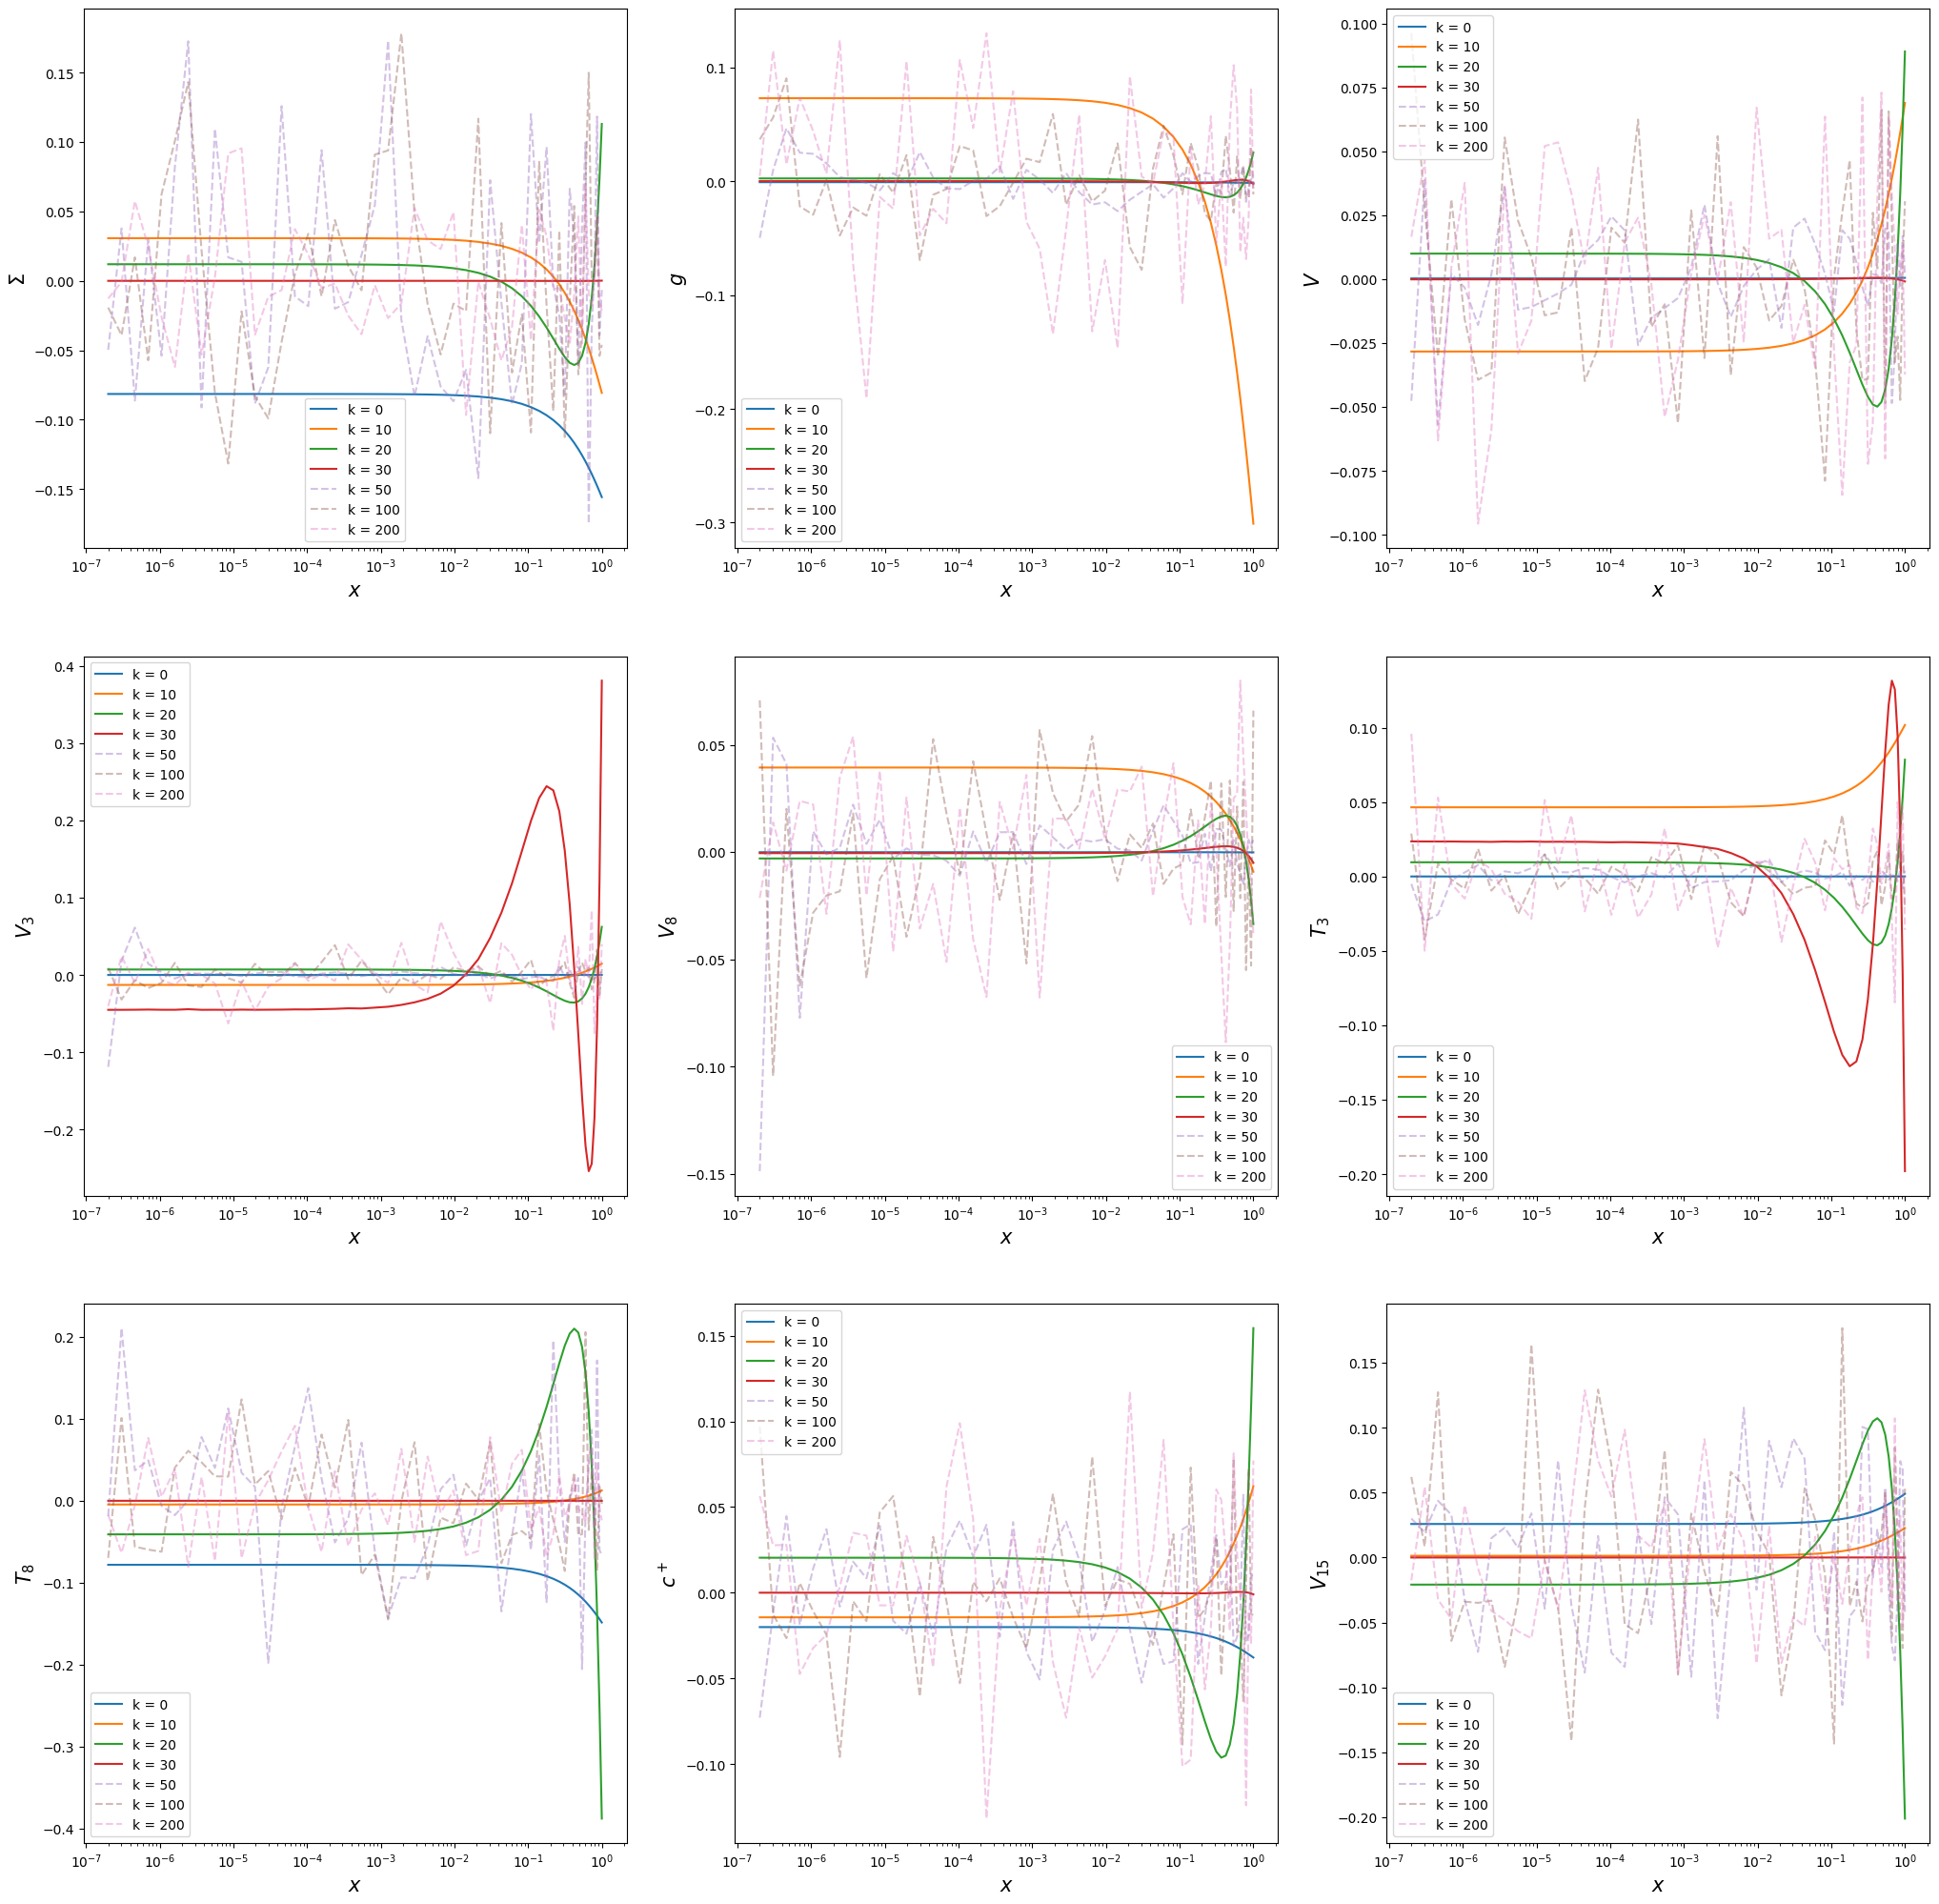

In [17]:
from utils import fk_ev_map
# Plot the components of the svd
fig_svd, axes_svd = plt.subplots(3,3, figsize=(25, 25))

for k in [0, 10, 20, 30, 50, 100, 200]:
  for idx, ax in enumerate(axes_svd.flat):
    vec = SVD_H_eigvecs_l[:, k]
    vec = vec.reshape(oldshape[:2])
    linestyle = 'dashed' if k > 40 else '-'
    alpha = 0.4 if k > 40 else 1.
    ax.plot(XGRID, vec[:,idx], label=f'k = {k}', linestyle=linestyle, alpha=alpha)
    ax.legend()
    if k == 0:
      ax.set_ylabel(fk_ev_map[idx], fontsize=15)
      ax.set_xscale('log')
      ax.set_xlabel(r'$x$', fontsize=15)

# Projection into the SV-basis

Recall that the SVD allows us to write *any* $n \times n$ **real** matrix H as
$$
\mathbf{H} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{T} \,,
$$
where $\mathbf{U}$ and $\mathbf{V}$ are $n \times n$ orthogonal matrices, and $\mathbf{\Sigma}$ is a $n \times n$ diagonal matrix with non-negative real numbers (the *singular values*) on the diagonal. The colums of $\mathbf{U}$ and $\mathbf{V}$ are called left-singular and right-singular vectors of $\mathbf{H}$, respectively. They form two different orthonormal bases $\mathbf{u}_1, \dots, \mathbf{u}_n$ and $\mathbf{v}_1, \dots, \mathbf{v}_n$, whose elements are associated with the singular values $\sigma_i$. The SVD can also be written as
$$
H_{ij} = \sum_{k=0}^{N_{SVD}} \sigma_k \bf{u}_i^{(k)} \bf{v}_i^{(k)} \,.
$$
It is easy to show that the eigenvalue equation generalises as follows
$$
\mathbf{H} \mathbf{v}^{(k)} = \sigma_k \mathbf{u}^{(k)} \\[10pt]
\mathbf{u}^{T(k)} \mathbf{H} = \sigma_k \mathbf{v}^{T(k)} \,.
$$

SVD provides orthonormal bases for the nullspace and *range* of a matrix. The columns of $\mathbf{U}$ whose respective singular values $\sigma_i$ are *nonzero* are an orthonormal set of basis vectors that span the range of the matrix. 

# Analytical solution to the gradient flow

In [18]:
from utils import produce_R_ev_9_to_flav_8, produce_R_flav_8_to_ev_9

def integrate_flow_t(t, eigvals, eigvecs, learning_rate=1.0, rotate=False):
  oldshape = f0.shape
  f0_flatten = f0.flatten()
  K_flatten = K.flatten()

  f0_tilde = [np.dot(f0_flatten, eigvecs[:, k]) for k in range(eigvals.size)]
  K_tilde = [np.dot(K_flatten, eigvecs[:, k]) for k in range(eigvals.size)]

  output = np.zeros(shape=K_flatten.shape[0])
  for k in range(eigvals.size):
      C1_k = f0_tilde[k] * np.exp(- eigvals[k] * learning_rate * t)
      C2_k = (1.0 - np.exp(- eigvals[k] * learning_rate * t) ) * K_tilde[k]
      output = np.add(output, (C1_k + C2_k) * eigvecs[:,k])

  output = output.reshape(oldshape)

  if rotate:
    R_ev_9_to_flav_8 = produce_R_ev_9_to_flav_8()
    integrated_preds_fl = R_ev_9_to_flav_8 @ output.T
  else:
    integrated_preds_fl = output.T
  return integrated_preds_fl


def integrate_flow_t_complex(t, eigvals=eigvals_complex, eigvecs=eigvecs_complex, learning_rate=1.0):
  oldshape = f0.shape
  f0_flatten = f0.flatten()
  K_flatten = K.flatten()

  f0_tilde = [np.vdot(eigvecs[:, k], f0_flatten) for k in range(eigvals.size)]
  K_tilde = [np.vdot(eigvecs[:, k], K_flatten) for k in range(eigvals.size)]

  output = np.zeros(shape=K_flatten.shape[0])
  for k in range(eigvals.size):
      C1_k = f0_tilde[k] * np.exp(- eigvals[k] * learning_rate * t)
      C2_k = (1.0 - np.exp(- eigvals[k] * learning_rate * t) ) * K_tilde[k]
      output = np.add(output, (C1_k + C2_k) * eigvecs[:,k])

  return output.reshape(oldshape)


def integrate_flow_t_svd(t, 
                         singular_values=SVD_H_eigvals_reg, 
                         left_sv=SVD_H_eigvecs_l, 
                         right_sv=SVD_H_eigvecs_r, 
                         learning_rate=1.0,
                         range_dec=None,
                         rotate=False):
  oldshape = f0.shape
  f0_flatten = f0.flatten()
  K_flatten = K.flatten()

  f0_tilde = [np.dot(f0_flatten, right_sv[:, k]) for k in range(singular_values.size)]
  K_tilde = [np.dot(K_flatten, right_sv[:, k]) for k in range(singular_values.size)]
  if range_dec is not None:
    range_decomposition = range_dec
  else:
    range_decomposition = (0,singular_values.size)

  output = np.zeros(shape=K_flatten.shape[0])
  for k in range(*range_decomposition):
      C1_k = np.exp(- singular_values[k] * learning_rate * t) * (f0_tilde[k] - K_tilde[k])
      C2_k = K_tilde[k]
      if t > 0.0:
        output = np.add(output, C1_k * left_sv[:,k] + C2_k * right_sv[:,k])
      else:
        output = np.add(output, C1_k * right_sv[:,k] + C2_k * right_sv[:,k])

  output = output.reshape(oldshape)

  if rotate:
    R_ev_9_to_flav_8 = produce_R_ev_9_to_flav_8()
    integrated_preds_fl = R_ev_9_to_flav_8 @ output.T
  else:
    integrated_preds_fl = output.T
  return integrated_preds_fl

## Train with GD

In [19]:
X = tf.convert_to_tensor(XGRID)
X = tf.reshape(X, shape=(-1,1))

nnpdf_w_preds = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed, name='NNPDF', kernel_initializer=tf.keras.initializers.GlorotNormal, predictions=True, fk_table_dict=fk_table_dict, dtype='float32')
predictions = nnpdf_w_preds(X)

# Define optimizer
learning_rate_gd = 0.0000005
learning_rate_adam = 0.001
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_gd)
custom_optimizer = False
predictions_in_time = []

for step in range(1000):  # Number of epochs/iterations
  with tf.GradientTape(persistent=False) as tape:
      # Forward pass: Compute predictions
      predictions = nnpdf_w_preds(X)
      #preds = [pred for pred in predictions.values()]

      loss = 0
      for exp, pred in predictions.items():
        Cinv_exp = tf.convert_to_tensor(Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy(), name=f'Cinv_{exp}', dtype='float32')
        R = tf.convert_to_tensor(pred - np.array(central_data_dict[exp]), name=f'residue_{exp}', dtype='float32')
        Cinv_R = tf.linalg.matvec(Cinv_exp, R)
        loss += 0.5 * tf.reduce_sum(tf.multiply(R, Cinv_R))

      gradients = tape.gradient(loss, nnpdf_w_preds.trainable_variables)

      if custom_optimizer:
        for grad, weight in zip(gradients, nnpdf_w_preds.weights):
          new_weights = weight.value - learning_rate_gd * grad
          weight.assign(new_weights)
      else:
        optimizer.apply_gradients(zip(gradients, nnpdf_w_preds.trainable_variables))

      if step % 100 == 0:
        print('------------------------')
        print(f"Step {step}, Loss: {loss.numpy()}")

  pdf_from_model = tf.keras.models.Sequential(nnpdf_w_preds.layers[:-1])
  predictions_in_time.append(pdf_from_model(X))

------------------------
Step 0, Loss: 164955.09375
------------------------
Step 100, Loss: 17089.056640625
------------------------
Step 200, Loss: 16150.328125
------------------------
Step 300, Loss: 17430.908203125
------------------------
Step 400, Loss: 15822.4091796875
------------------------
Step 500, Loss: 14780.0263671875
------------------------
Step 600, Loss: 14016.6103515625
------------------------
Step 700, Loss: 13451.54296875
------------------------
Step 800, Loss: 13035.1396484375
------------------------
Step 900, Loss: 12735.408203125


### Load external PDF set

In [20]:
from utils import PID_map, flavour_map

pdf = API.pdf(pdf="240203-02-ak-ht-tcm-disonly")
pdf_loaded = pdf.load()
pdf_central = pdf_loaded.central_member

pdf_outs = []
for x in XGRID:
  aux = pdf_central.xfxQ2(x, 1.65**2)
  pdf_outs.append([ aux[PID_map[i['fl']]] for i in flavour_map])

pdf_outs = np.array(pdf_outs)

#output_fk = layer_evln(rotmat(pdf_outs))

LHAPDF 6.5.4 loading all 501 PDFs in set 240203-02-ak-ht-tcm-disonly
240203-02-ak-ht-tcm-disonly, version 1; 501 PDF members


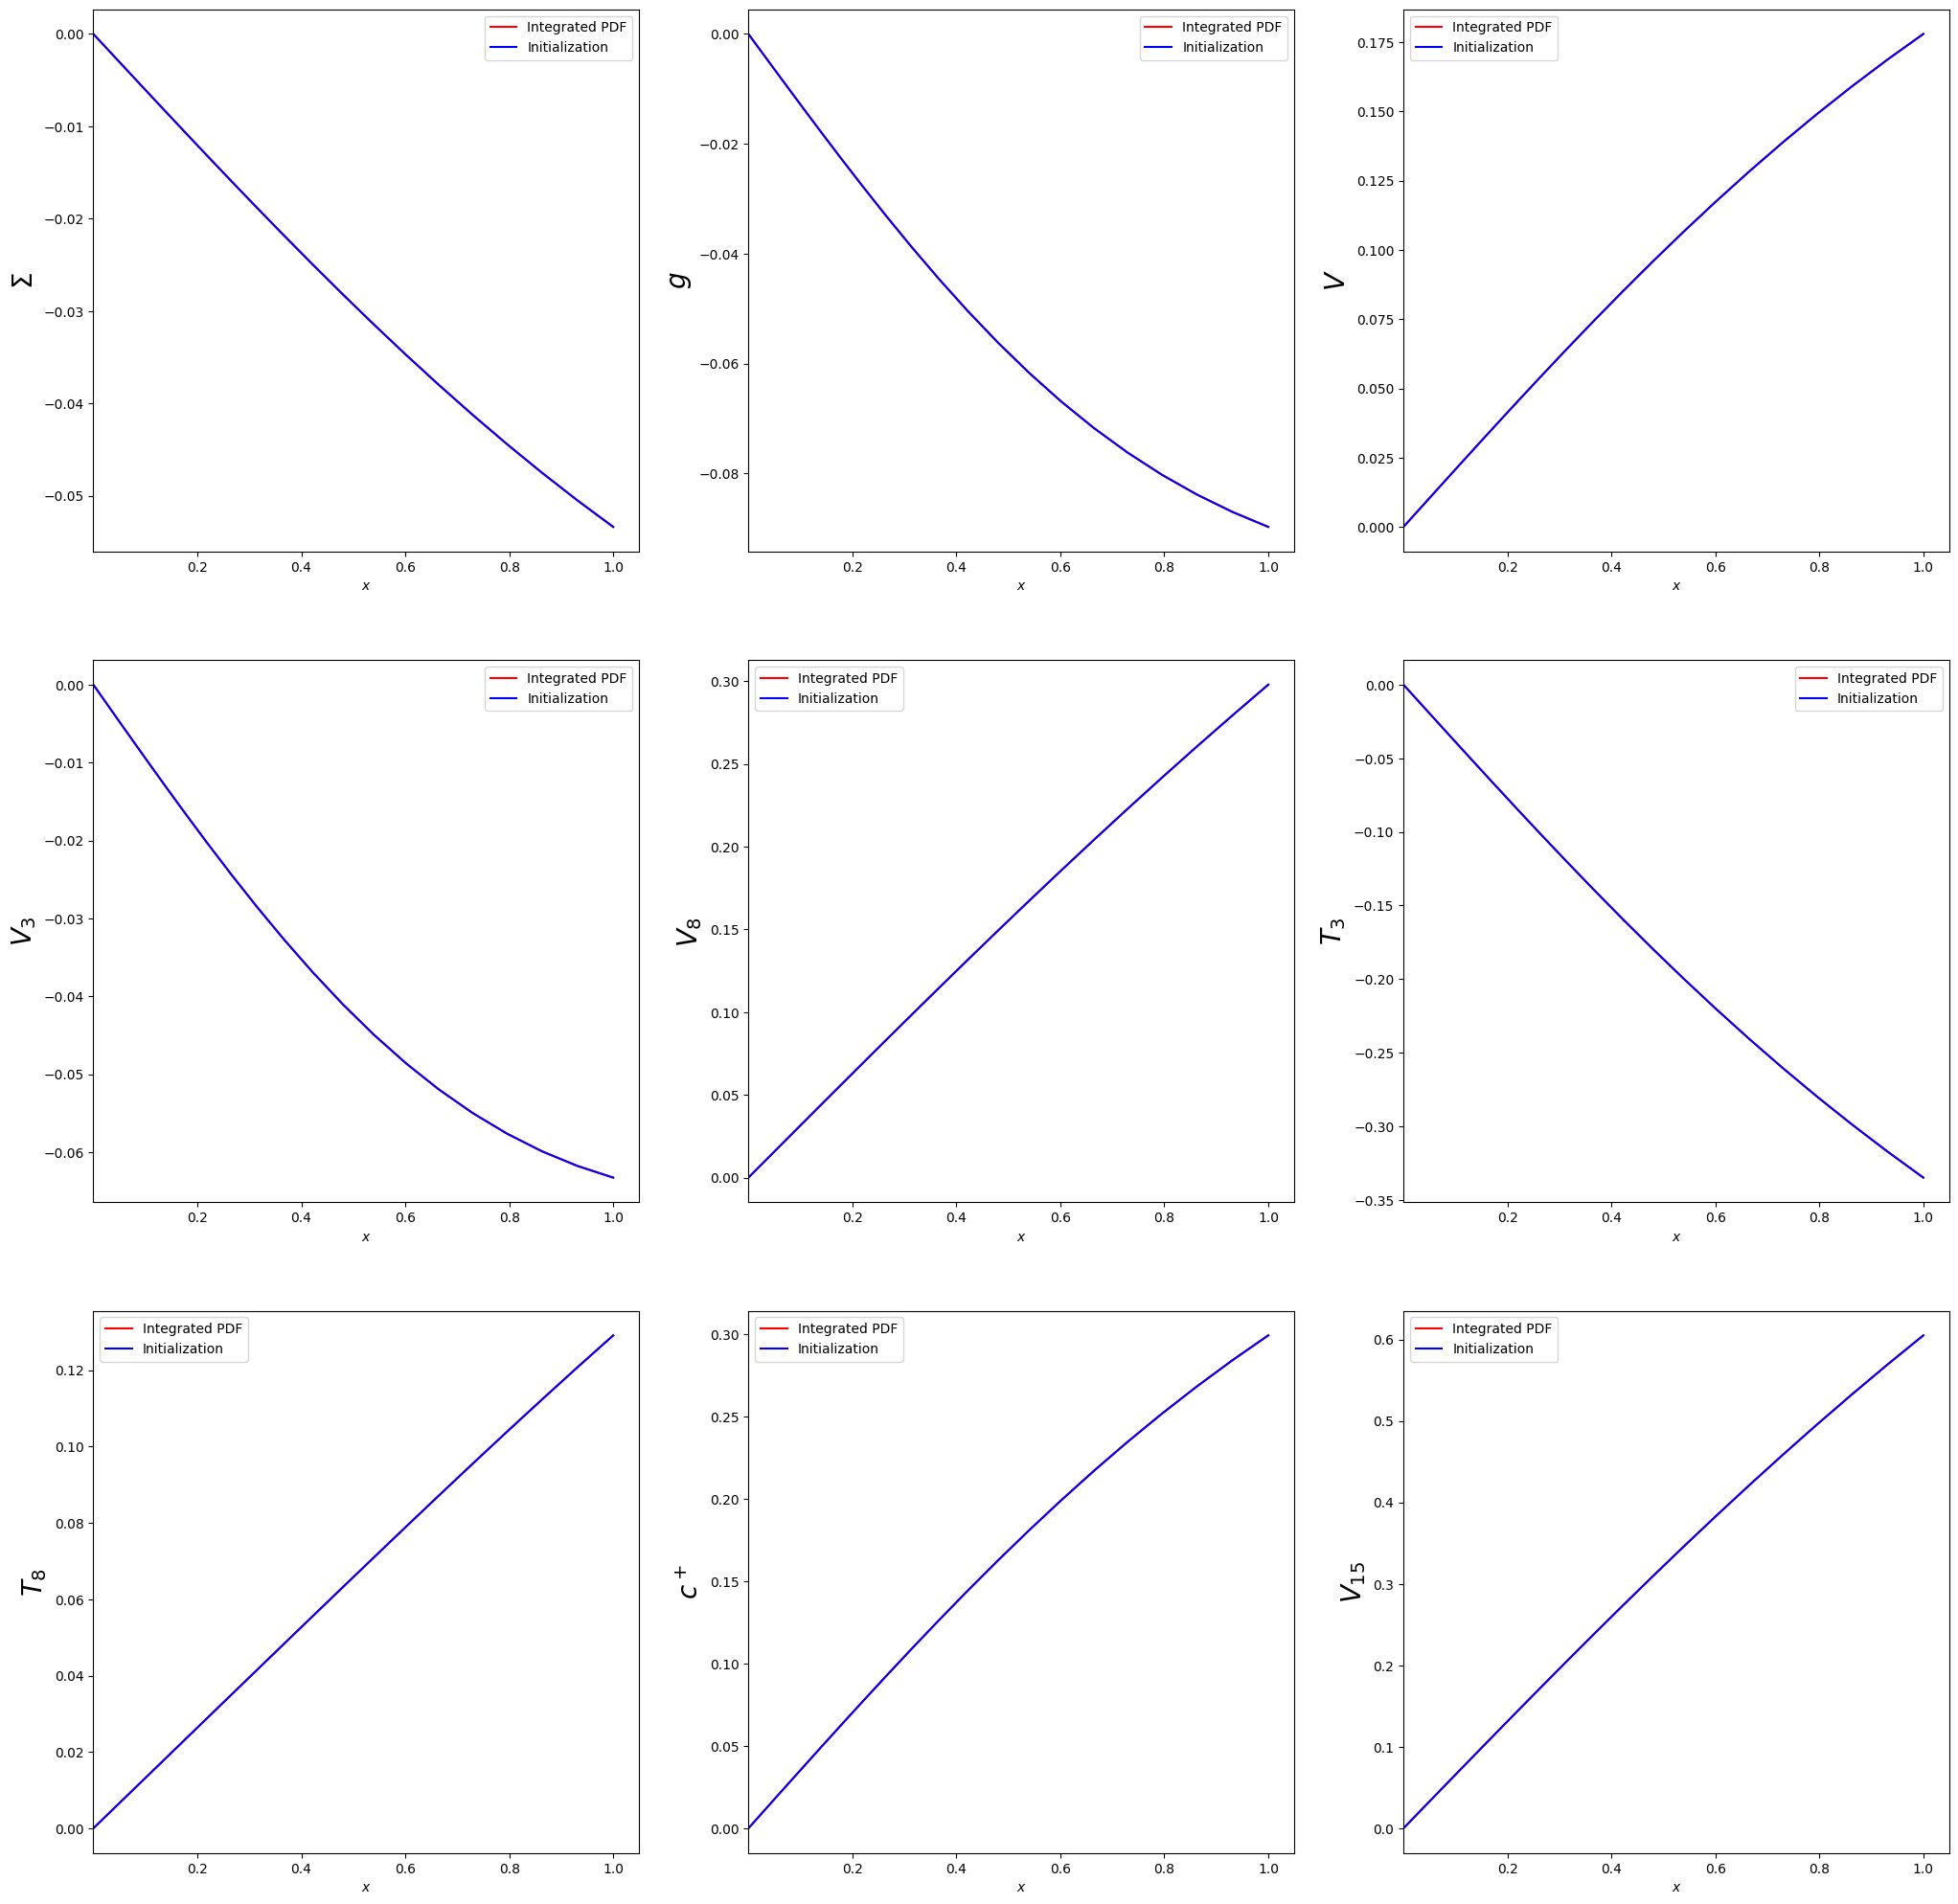

In [21]:
from matplotlib.animation import FuncAnimation
import matplotlib
from utils import fk_ev_map
matplotlib.rcParams['animation.embed_limit'] = 2**128

fig, axes = plt.subplots(3, 3, figsize=(25, 25))  # Adjust figsize for desired plot size

lines = []

for i, ax in enumerate(axes.flat):

    line, = ax.plot(XGRID, integrate_flow_t_svd(0.0, learning_rate=1.0, rotate=False)[i,:], 
                    color='red', label='Integrated PDF')
    #ax.plot(XGRID, trained_preds_fk_ev.T[i,:], color='blue', label='Trained PDF (GD)')
    ax.plot(XGRID, f0.T[i,:], color='blue', label='Initialization')
    #ax.plot(XGRID, pdf_outs[:,i], color='blue', label='Ext. PDF')
    lines.append(line)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(fk_ev_map[i], fontsize=20)
    #ax.set_xscale('log')
    ax.set_xlim(1e-5,1.05)
    ax.legend()
# Adjust layout to prevent overlapping titles and labels
#axes[-1, -1].axis('off')
#plt.tight_layout


In [22]:

# Animation function
def update(t):
    print(f'Updating time: {t}')
    for i, line in enumerate(lines):
        # Update the y-data for each subplot's line
        line.set_ydata(integrate_and_rotate(t, learning_rate=learning_rate_gd)[i,:])  # Example: Add phase shift based on t and subplot index
    return lines

from IPython.display import HTML
ani = FuncAnimation(fig, update, frames=np.arange(0., 700000.0, 1000.0), interval=50, blit=True, cache_frame_data=False)

# Save the animation in the background
ani.save('animation.mp4', writer='ffmpeg', fps=20)

HTML(ani.to_jshtml())

Updating time: 0.0


NameError: name 'integrate_and_rotate' is not defined

In [ ]:
Mr_SVD = np.linalg.svd(Mr)
H_SVD = np.linalg.svd(H)

In [ ]:
H_SVD[1] / H_SVD[1][0] 

In [ ]:
plt.semilogy(H_SVD[1] / H_SVD[1][0])

In [ ]:
Mr_SVD[1] / Mr_SVD[1][0] 

In [ ]:
plt.semilogy(Mr_SVD[1] / Mr_SVD[1][0])

In [ ]:
(Mr_SVD[0] @ Mr_SVD[0].T).diagonal()